You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os
#"""
if not os.path.isdir('k'):
 !git clone -b development14 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
#"""
!cd k && pip install .

HEAD is now at 370653a Adding new kTypes.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/joaopauloschuler/k-neural-api
   370653a..962de26  development14 -> origin/development14
Updating 370653a..962de26
Fast-forward
 cai/datasets.py | 5 ++++-
 1 file changed, 4 insertions(+), 1 deletion(-)
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.5-py3-none-any.whl size=57350 sha256=10d8322

In [22]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
import cv2
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.76702208 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Tue Nov 23 04:32:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [5]:
if not os.path.isdir('up'):
  !git clone https://github.com/joaopauloschuler/PlantDoc-Object-Detection-Dataset.git up

In [6]:
up_data_dir = os.getcwd()+"/up/TRAIN"
up_test_dir = os.getcwd()+"/up/TEST"
data_dir = "cropped_train/"
test_dir = "cropped_test/"
all_dir = "cropped_all/"

In [7]:
def CropImages(orig_data_dir, dest_data_dir, csv_file, include_original=False, verbose=True, prefix='img_'):
  # Load the CSV file.
  with open (csv_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(',')
      a_lines.append(a_line)
    line_count = line_count + 1
  #a_lines = np.array(a_lines, dtype=object)
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+a_line[3]
    dest_file_name = dest_folder_name+'/'+prefix+str(line_count)+'.jpg'
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    print(line_count,':', a_line, dest_file_name)
    if last_image_file != orig_file_name:
      if os.path.isfile(orig_file_name):
        img = cv2.imread(orig_file_name)
        #cv2_imshow(img)
        last_image_file = orig_file_name
        can_load = True
        original_count = original_count + 1
        if verbose: print("Original imgage shape",img.shape)
        if (include_original):
          if not os.path.isdir(dest_folder_name):
            os.mkdir(dest_folder_name)
          cv2.imwrite(dest_folder_name+'/ori_'+prefix+str(original_count)+'.jpg',img)  
      else:
        if verbose: print('File does not exist:', orig_file_name)
        can_load = False
        #break
    if (can_load):
      y1 = int(a_line[4])
      x1 = int(a_line[5])
      y2 = int(a_line[6])
      x2 = int(a_line[7])

      x_min = np.min([x1, x2])
      x_max = np.max([x1, x2])
      y_min = np.min([y1, y2])
      y_max = np.max([y1, y2])

      crop_img = img[x_min:x_max, y_min:y_max]
      if verbose: print("Cropped imgage shape",crop_img.shape,':', x_min, x_max, y_min, y_max,' deltas:',x_max - x_min, y_max - y_min)
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if ( (crop_img.shape[0]==0) or (crop_img.shape[1]==0)):
        failed_count = failed_count + 1
        if verbose: print("Failed cropping.");
      else:
        cv2.imwrite(dest_file_name,crop_img)
    else:
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [8]:
if not os.path.isdir(data_dir):
  CropImages(orig_data_dir=up_data_dir, dest_data_dir=data_dir, csv_file='up/train_labels.csv', include_original=False, prefix='train_')

In [9]:
if not os.path.isdir(test_dir):
  CropImages(orig_data_dir=up_test_dir, dest_data_dir=test_dir, csv_file='up/test_labels.csv', include_original=False, prefix='test_')

In [10]:
print(os.listdir(data_dir))
print(os.listdir(test_dir))
if not os.path.isdir('cropped_test/Potato leaf'):
  !mkdir 'cropped_test/Potato leaf'
if not os.path.isdir('cropped_test/Tomato two spotted spider mites leaf'):
  !mkdir 'cropped_test/Tomato two spotted spider mites leaf'

['Apple rust leaf', 'Tomato leaf late blight', 'Raspberry leaf', 'Peach leaf', 'grape leaf', 'Bell_pepper leaf spot', 'Bell_pepper leaf', 'Tomato Septoria leaf spot', 'Apple Scab Leaf', 'Corn leaf blight', 'Tomato mold leaf', 'Squash Powdery mildew leaf', 'Tomato two spotted spider mites leaf', 'grape leaf black rot', 'Tomato leaf mosaic virus', 'Tomato leaf bacterial spot', 'Tomato Early blight leaf', 'Potato leaf late blight', 'Tomato leaf yellow virus', 'Potato leaf early blight', 'Corn rust leaf', 'Cherry leaf', 'Tomato leaf', 'Potato leaf', 'Corn Gray leaf spot', 'Apple leaf', 'Strawberry leaf', 'Soyabean leaf', 'Blueberry leaf']
['Apple rust leaf', 'Tomato leaf late blight', 'Raspberry leaf', 'Peach leaf', 'grape leaf', 'Bell_pepper leaf spot', 'Bell_pepper leaf', 'Tomato Septoria leaf spot', 'Apple Scab Leaf', 'Corn leaf blight', 'Tomato mold leaf', 'Squash Powdery mildew leaf', 'Tomato two spotted spider mites leaf', 'grape leaf black rot', 'Tomato leaf mosaic virus', 'Tomato l

In [11]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [12]:
if not os.path.isdir(all_dir):
  !mkdir cropped_all
  ! cp -r cropped_test/* cropped_all/
  ! cp -r cropped_train/* cropped_all/

In [13]:
datagen = cai.util.create_image_generator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.1) 

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [14]:
num_classes = 29
batch_size = 64
epochs = 75
target_size_x = 224 # default value is 224
target_size_y = 224 # default value is 224

In [15]:
train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=all_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='plant_doc',
  has_training=True, has_validation=True, has_testing=True,
  smart_resize=True,
  training_size=0.65, validation_size=0.15, test_size=0.2,
  target_size=(target_size_x, target_size_y))

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Loading  29  classes.
smart resize is enabled.
loading train images
train shape is: (5761, 224, 224, 3)
loading validation images
validation shape is: (1333, 224, 224, 3)
loading test images
test shape is: (1789, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
Loaded.
(5761, 224, 224, 3) (1333, 224, 224, 3) (1789, 224, 224, 3)
(5761, 29) (1333, 29) (1789, 29)


In [16]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6_32ch()]:
      basefilename = 'JP30A05-EfficientNet-CroppedPlantDoc-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      
      if kType==-1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)

      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary()
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit):
        history = model.fit(
          x = datagen.flow(train_x, train_y, batch_size=batch_size),
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
          workers=max([multiprocessing.cpu_count(), 4]) # this option 
          )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        print('Best Model Results: '+basefilename)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(test_x,test_y)
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        pred_y = model.predict(test_x)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show Models

In [17]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False)

Running: JP30A05-EfficientNet-CroppedPlantDoc-13
Model: "kEffNet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 k_stem_conv_pad (ZeroPadding2D  (None, 225, 225, 3)  0          ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 k_stem_conv (Conv2D)           (None, 112, 112, 32  864         ['k_stem_conv_pad[0][0]']        
                                )       

# Fitting

Running: JP30A05-EfficientNet-CroppedPlantDoc-13
Epoch 1/75
91/91 [==============================] - ETA: 0s - loss: 3.7468 - accuracy: 0.0923
Epoch 00001: val_accuracy improved from -inf to 0.09527, saving model to JP30A05-EfficientNet-CroppedPlantDoc-13-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


91/91 [==============================] - 116s 556ms/step - loss: 3.7468 - accuracy: 0.0923 - val_loss: 3.1954 - val_accuracy: 0.0953 - lr: 0.0010
Epoch 2/75
91/91 [==============================] - ETA: 0s - loss: 3.3930 - accuracy: 0.1142
Epoch 00002: val_accuracy did not improve from 0.09527
91/91 [==============================] - 39s 411ms/step - loss: 3.3930 - accuracy: 0.1142 - val_loss: 3.1717 - val_accuracy: 0.0953 - lr: 0.0015
Epoch 3/75
91/91 [==============================] - ETA: 0s - loss: 3.3320 - accuracy: 0.1298
Epoch 00003: val_accuracy did not improve from 0.09527
91/91 [==============================] - 39s 407ms/step - loss: 3.3320 - accuracy: 0.1298 - val_loss: 3.1659 - val_accuracy: 0.0915 - lr: 0.0020
Epoch 4/75
91/91 [==============================] - ETA: 0s - loss: 3.1443 - accuracy: 0.1429
Epoch 00004: val_accuracy did not improve from 0.09527
91/91 [==============================] - 39s 411ms/step - loss: 3.1443 - accuracy: 0.1429 - val_loss: 4.4852 - val_ac

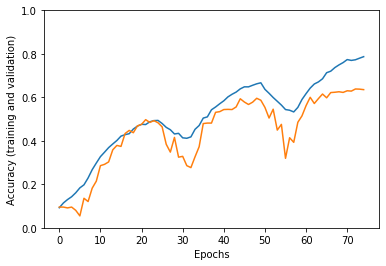

In [18]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [19]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True)

Running: JP30A05-EfficientNet-CroppedPlantDoc-13
Best Model Results: JP30A05-EfficientNet-CroppedPlantDoc-13
56/56 [==============================] - 14s 60ms/step - loss: 1.2206 - accuracy: 0.6574
loss 1.2206103801727295
acc 0.657350480556488
Finished: JP30A05-EfficientNet-CroppedPlantDoc-13


# Calculate F1

In [23]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True, calc_f1=True)

Running: JP30A05-EfficientNet-CroppedPlantDoc-13
Best Model Results: JP30A05-EfficientNet-CroppedPlantDoc-13
56/56 [==============================] - 15s 61ms/step - loss: 1.2206 - accuracy: 0.6574
loss 1.2206103801727295
acc 0.657350480556488
Predicted Shape: (1789, 29)
Pred classes shape: (1789,)
Test classes shape: (1789,)
              precision    recall  f1-score   support

           0     0.5769    0.4286    0.4918        35
           1     0.6053    0.4600    0.5227        50
           2     0.6923    0.5000    0.5806        36
           3     0.8269    0.6615    0.7350        65
           4     0.5333    0.4528    0.4898        53
           5     0.7679    0.7633    0.7656       169
           6     0.4561    0.5417    0.4952        48
           7     0.4000    0.1250    0.1905        16
           8     0.7765    0.8919    0.8302        74
           9     0.6250    0.7692    0.6897        26
          10     0.8291    0.7823    0.8050       124
          11     0.5000

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
